# Random Coefficients Logit Tutorial with the Fake Cereal Data

In [24]:
import pyblp
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.0'

## Loading Data

The `product_data` argument of [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem) should be a structured array-like object with fields that store data. Product data can be a structured [NumPy](https://numpy.org/) array, a [pandas](https://pandas.pydata.org/) DataFrame, or other similar objects.

In [3]:
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.012417,0.072088,2,1,...,2.116358,-0.154708,-0.005796,0.014538,0.126244,0.067345,0.068423,0.034800,0.126346,0.035484
1,C01Q1,1,1,F1B06,1,6,0.007809,0.114178,18,1,...,-7.374091,-0.576412,0.012991,0.076143,0.029736,0.087867,0.110501,0.087784,0.049872,0.072579
2,C01Q1,1,1,F1B07,1,7,0.012995,0.132391,4,1,...,2.187872,-0.207346,0.003509,0.091781,0.163773,0.111881,0.108226,0.086439,0.122347,0.101842
3,C01Q1,1,1,F1B09,1,9,0.005770,0.130344,3,0,...,2.704576,0.040748,-0.003724,0.094732,0.135274,0.088090,0.101767,0.101777,0.110741,0.104332
4,C01Q1,1,1,F1B11,1,11,0.017934,0.154823,12,0,...,1.261242,0.034836,-0.000568,0.102451,0.130640,0.084818,0.101075,0.125169,0.133464,0.121111


In [27]:
path = "/Users/hanazawakaede/Library/CloudStorage/Dropbox/02_Projects/Airbnb/01_analysis/nevo.csv"
# product_dataを指定されたパスに書き出し
product_data.to_csv(path, index=False)

The product data contains `market_ids`, `product_ids`, `firm_ids`, `shares`, `prices`, a number of other firm IDs and product characteristics, and some pre-computed excluded `demand_instruments0`, `demand_instruments1`, and so on. The `product_ids` will be incorporated as fixed effects. 

For more information about the instruments and the example data as a whole, refer to the [`data`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.data.html#module-pyblp.data) module.

## Setting Up and Solving the Problem Without Demographics

Formulations, product data, and an integration configuration are collectively used to initialize a [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem). Once initialized, [`Problem.solve`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.solve.html#pyblp.Problem.solve) runs the estimation routine. The arguments to [`Problem.solve`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.solve.html#pyblp.Problem.solve) configure how estimation is performed. For example, `optimization` and `iteration` arguments configure the optimization and iteration routines that are used by the outer and inner loops of estimation.

We'll specify [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) configurations for $X_1$, the demand-side linear characteristics, and $X_2$, the nonlinear characteristics.

- The formulation for $X_1$ consists of `prices` and fixed effects constructed from `product_ids`, which we will absorb using `absorb` argument of [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation).
- If we were interested in reporting estimates for each fixed effect, we could replace the formulation for $X_1$ with `Formulation('prices + C(product_ids)')`.
- Because `sugar`, `mushy`, and the constant are collinear with `product_ids`, we can include them in $X_2$ but not in $X_1$.

In [20]:
X1_formulation = pyblp.Formulation('0 + prices', absorb='C(product_ids)')
X2_formulation = pyblp.Formulation('1 + prices + sugar + mushy')
product_formulations = (X1_formulation, X2_formulation)

mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})

In [22]:
results = mc_problem.solve(sigma=np.ones((4, 4)), optimization=bfgs)
results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +1.5E+02   +8.7E-05     +8.5E-02        +6.5E+03        0         +5.2E+07          +8.3E+05     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:17       Yes          58           75          83991       258115   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |  Sigma Squared:      1         prices      sugar       mushy   
------  ----------  ----------  ----------  ---

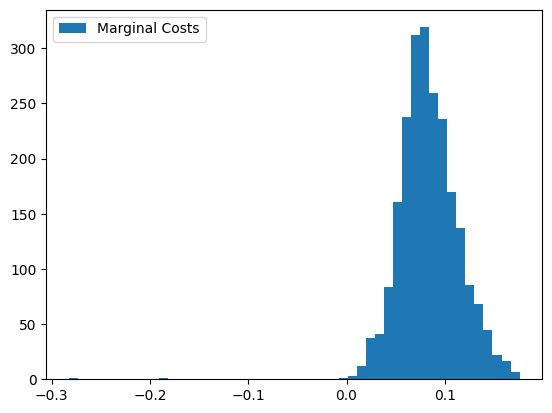

In [25]:
costs = results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);